In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.stats import skew, kurtosis

In [23]:
DATA_PATH = "../data/daily/us"

def load_data(symbol, base_path=DATA_PATH):
    search_patterns = [
        os.path.join(base_path, "**", f"{symbol.lower()}.us.txt"),
        os.path.join(base_path, "nyse stocks", "**", f"{symbol.lower()}.us.txt"),
        os.path.join(base_path, "nasdaq stocks", "**", f"{symbol.lower()}.us.txt"),
    ]
    
    files = []
    for pattern in search_patterns:
        files = glob.glob(pattern, recursive=True)
        if files:
            break
    
    if not files:
        return None
    
    try:
        df = pd.read_csv(files[0])
        df.columns = [c.replace('<', '').replace('>', '').capitalize() for c in df.columns]
        
        if 'Vol' in df.columns:
            df.rename(columns={'Vol': 'Volume'}, inplace=True)
        
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
            df.set_index('Date', inplace=True)
        elif 'Time' in df.columns:
            df['Time'] = pd.to_datetime(df['Time'], format='%Y%m%d')
            df.set_index('Time', inplace=True)
            df.index.name = 'Date'
        
        if 'Volume' not in df.columns:
            df['Volume'] = 0
            
        return df.dropna(subset=['Open', 'High', 'Low', 'Close'])
        
    except:
        return None


In [24]:
def calculate_metrics(stock_data, symbols):
    for s in symbols:
        if s not in stock_data or stock_data[s] is None:
            continue
            
        df = stock_data[s]
        
        # Returns
        df['ret_simple'] = df['Close'].pct_change()
        df['ret_log'] = np.log(df['Close'] / df['Close'].shift(1))
        
        # Rolling stats for 10, 20, 60, 252 days
        for window in [10, 20, 60, 252]:
            df[f'roll_mean_{window}'] = df['ret_simple'].rolling(window=window).mean()
            df[f'roll_std_{window}'] = df['ret_simple'].rolling(window=window).std()
            df[f'ann_vol_{window}'] = df[f'roll_std_{window}'] * np.sqrt(252)
        
        stock_data[s] = df
    
    return stock_data

In [25]:
def create_plots(stock_data, symbols, ew_cumulative, vw_cumulative):
    """
    Creates 4 visualizations and saves to PNG file
    """
    valid_symbols = [s for s in symbols if s in stock_data]
    
    if len(valid_symbols) == 0:
        print("No data for plots")
        return
    
    plt.style.use('dark_background')
    fig, axes = plt.subplots(4, 1, figsize=(14, 20))
    
    # 1. Normalized Price Series (first 5 stocks)
    ax1 = axes[0]
    for s in valid_symbols[:5]:
        df = stock_data[s]
        normalized = df['Close'] / df['Close'].iloc[0]
        ax1.plot(normalized, label=s, linewidth=1.5, alpha=0.9)
    ax1.set_title("Normalized Price Series (Base = 1.0)", fontsize=14)
    ax1.set_ylabel("Normalized Price")
    ax1.legend(loc='upper left')
    ax1.grid(alpha=0.3)
    
    # 2. Return Distribution Histogram (first stock)
    ax2 = axes[1]
    sample_stock = valid_symbols[0]
    rets = stock_data[sample_stock]['ret_simple'].dropna()
    ax2.hist(rets, bins=50, color='#3498db', alpha=0.7, edgecolor='white')
    ax2.axvline(rets.mean(), color='#e74c3c', linestyle='--', 
                label=f'Mean: {rets.mean():.4f}', linewidth=2)
    ax2.set_title(f"{sample_stock} Daily Return Distribution", fontsize=14)
    ax2.set_xlabel("Daily Return")
    ax2.set_ylabel("Frequency")
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # 3. Annualized Volatility
    ax3 = axes[2]
    sample_stock = valid_symbols[0]
    df = stock_data[sample_stock]
    ax3.plot(df['ann_vol_20'], label='20-Day Vol', color='#2ecc71', alpha=0.7, linewidth=1)
    ax3.plot(df['ann_vol_252'], label='252-Day Vol', color='#f39c12', linewidth=2)
    ax3.set_title(f"{sample_stock} Annualized Volatility", fontsize=14)
    ax3.set_ylabel("Annualized Volatility")
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. Portfolio Performance
    ax4 = axes[3]
    ax4.plot(ew_cumulative, label='Equal-Weight', color='#3498db', linewidth=2)
    ax4.plot(vw_cumulative, label='Value-Weight', color='#e74c3c', linewidth=2)
    ax4.set_title("Portfolio Cumulative Returns: EW vs VW", fontsize=14)
    ax4.set_xlabel("Date")
    ax4.set_ylabel("Growth of $1")
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Save to file
    output_file = 'week1_analysis.png'
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    print(f"\nPlots saved to: {output_file}")
    
    # Also display if in Jupyter
    plt.show()

In [26]:
def main():
    symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'V', 'UNH']
    
    # Load data
    stock_data = {}
    for s in symbols:
        df = load_data(s)
        if df is not None:
            stock_data[s] = df
    
    # Calculate metrics
    stock_data = calculate_metrics(stock_data, symbols)
    
    # Print last 10 days of returns and rolling stats
    for s in symbols:
        if s in stock_data:
            df = stock_data[s]
            print(f"\n{s}")
            last_10 = df.tail(10)[['Close', 'ret_simple', 'ret_log', 
                                     'roll_mean_10', 'roll_std_10', 'ann_vol_10',
                                     'roll_mean_20', 'roll_std_20', 'ann_vol_20']]
            print(last_10.to_string())
    
    # Distribution stats
    print("\n\nDISTRIBUTION STATS")
    for s in symbols:
        if s in stock_data:
            rets = stock_data[s]['ret_simple'].dropna()
            print(f"\n{s}")
            print(f"Mean: {rets.mean()}")
            print(f"Std: {rets.std()}")
            print(f"Skewness: {skew(rets)}")
            print(f"Kurtosis: {kurtosis(rets)}")
            print(f"Min: {rets.min()}")
            print(f"Max: {rets.max()}")
    
    # Portfolio returns
    valid_symbols = [s for s in symbols if s in stock_data]
    all_rets = pd.DataFrame({s: stock_data[s]['ret_simple'] for s in valid_symbols}).dropna()
    
    # Equal weight
    ew_returns = all_rets.mean(axis=1)
    ew_cumulative = (1 + ew_returns).cumprod()
    
    # Value weight
    dollar_vols = pd.DataFrame({
        s: stock_data[s]['Close'] * stock_data[s]['Volume']
        for s in all_rets.columns
    }).loc[all_rets.index]
    weights = dollar_vols.div(dollar_vols.sum(axis=1), axis=0).fillna(0)
    vw_returns = (all_rets * weights).sum(axis=1)
    vw_cumulative = (1 + vw_returns).cumprod()
    
    print("\n\nPORTFOLIO")
    print(f"Period: {all_rets.index.min()} to {all_rets.index.max()}")
    print(f"Days: {len(all_rets)}")
    print(f"Equal-Weight Final: {ew_cumulative.iloc[-1]}")
    print(f"Value-Weight Final: {vw_cumulative.iloc[-1]}")
    
    years = (all_rets.index[-1] - all_rets.index[0]).days / 365.25
    print(f"EW Annualized Return: {(ew_cumulative.iloc[-1] ** (1/years)) - 1}")
    print(f"VW Annualized Return: {(vw_cumulative.iloc[-1] ** (1/years)) - 1}")
    
    # Create plots
    create_plots(stock_data, symbols, ew_cumulative, vw_cumulative)
    
    return stock_data



AAPL
              Close  ret_simple   ret_log  roll_mean_10  roll_std_10  ann_vol_10  roll_mean_20  roll_std_20  ann_vol_20
Date                                                                                                                   
2026-01-15  258.210   -0.006732 -0.006755     -0.005116     0.007035    0.111679     -0.003053     0.006632    0.105285
2026-01-16  255.530   -0.010379 -0.010433     -0.005841     0.007180    0.113973     -0.003068     0.006649    0.105549
2026-01-20  246.700   -0.034556 -0.035167     -0.007913     0.011458    0.181892     -0.004860     0.009592    0.152273
2026-01-21  247.650    0.003851  0.003843     -0.005694     0.011363    0.180389     -0.004939     0.009509    0.150949
2026-01-22  248.350    0.002827  0.002823     -0.004638     0.011640    0.184781     -0.004305     0.009586    0.152173
2026-01-23  248.040   -0.001248 -0.001249     -0.004267     0.011688    0.185538     -0.004624     0.009359    0.148570
2026-01-26  255.410    0.029713  0

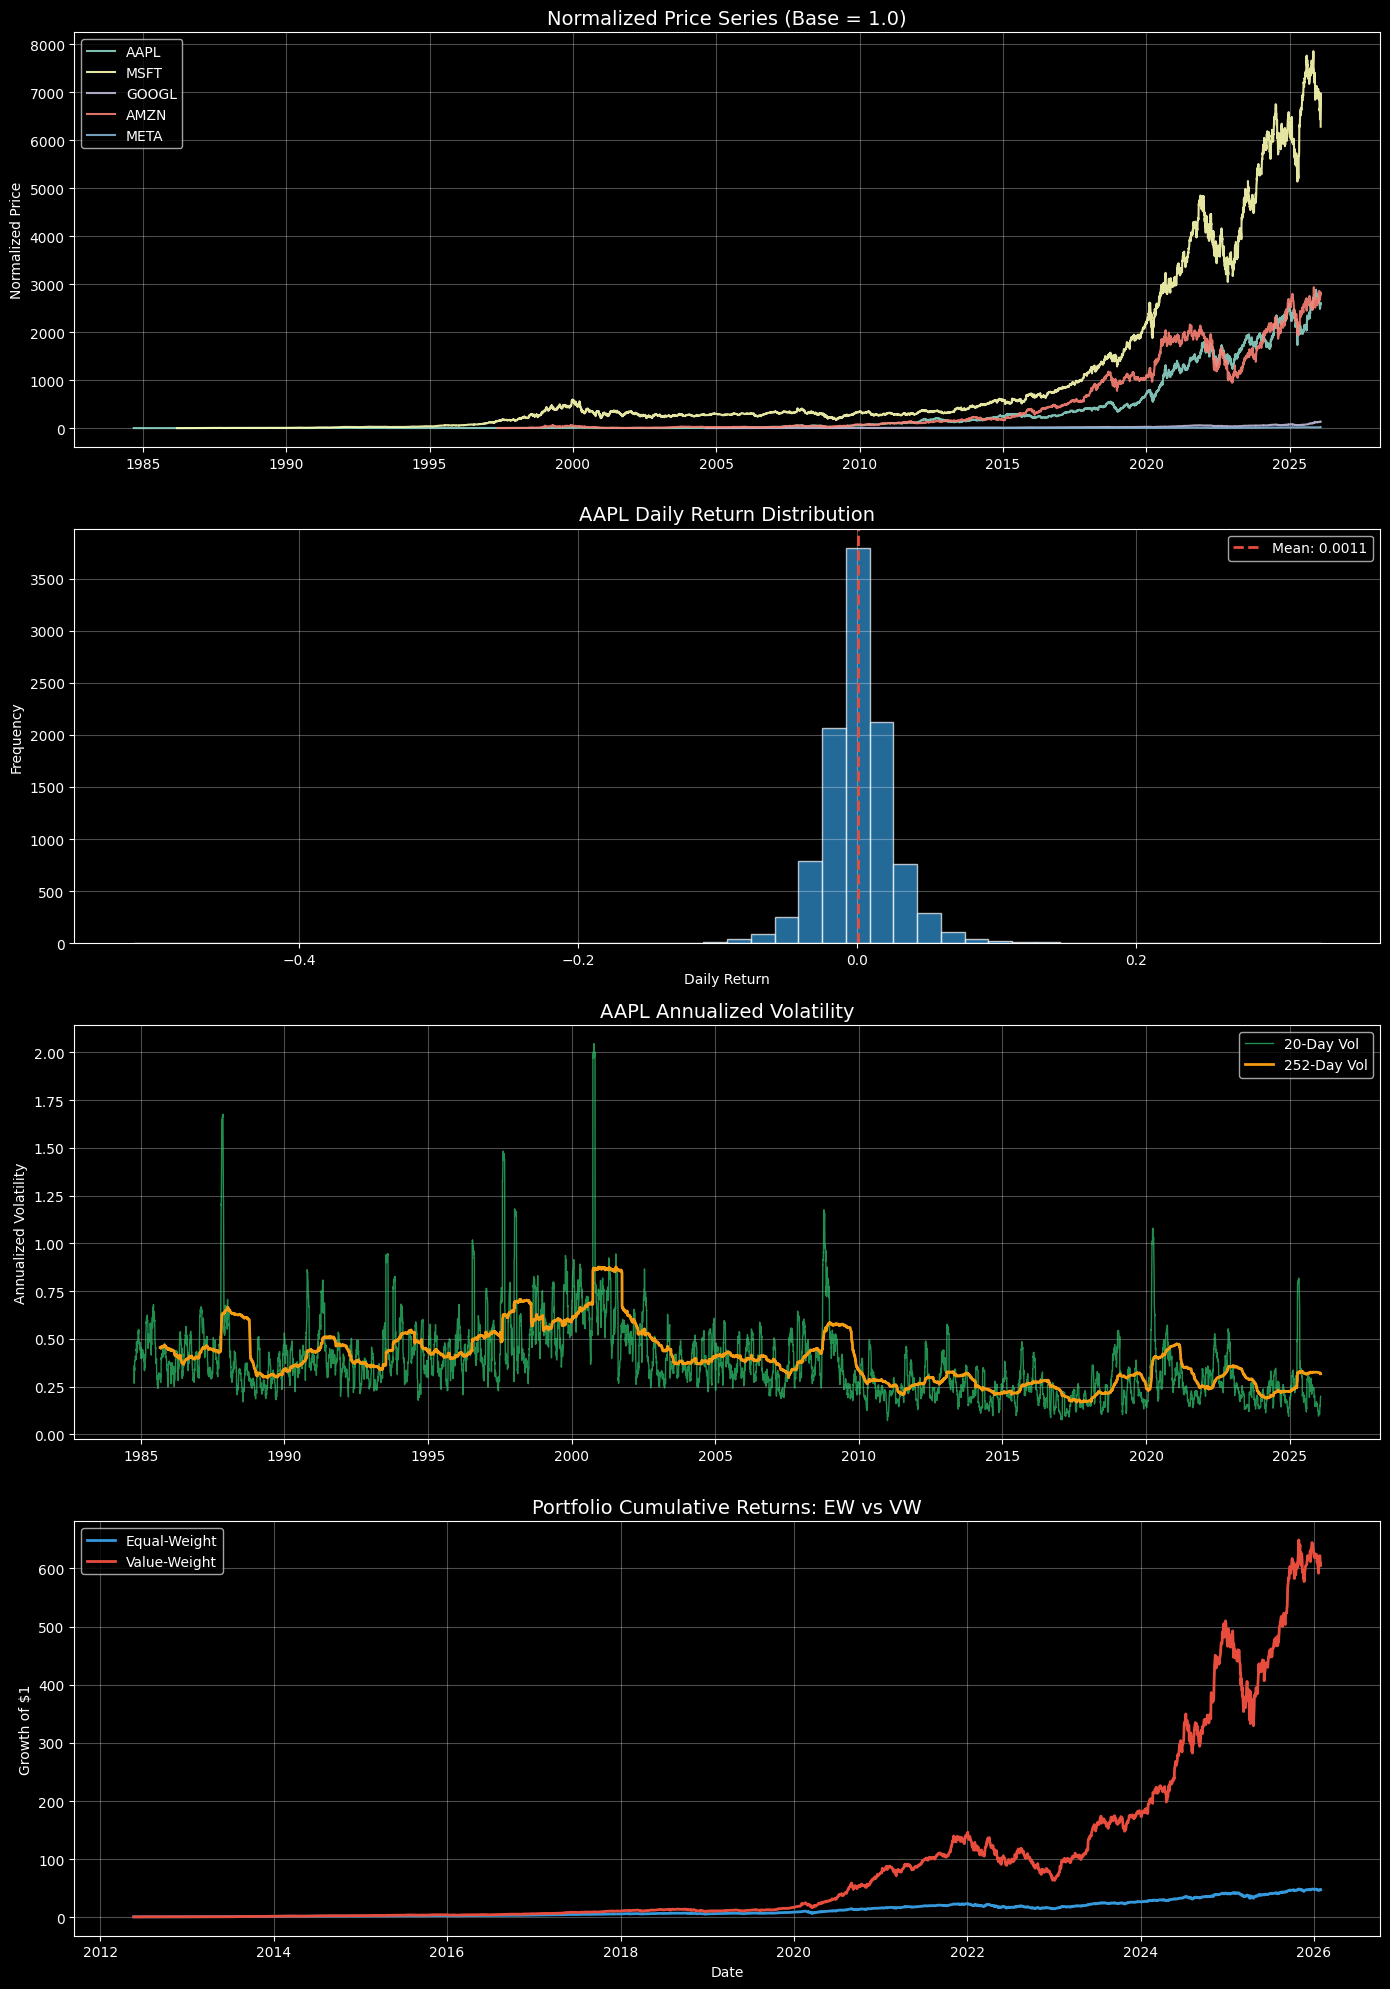

In [27]:
if __name__ == "__main__":
    stock_data = main()